<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import nltk
import re
import spacy


# импорты модулей текущего проекта
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split
)

from catboost import CatBoostClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# настройки
warnings.filterwarnings("ignore")

# константы заглавными буквами
RANDOM_STATE = 12345

In [2]:
#Считываем данные из csv-файла в датафрейм
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0], parse_dates=[0])

In [3]:
#data = data.sample(5000).reset_index(drop=True)

In [4]:
#Функция получения первичной информации о датафрейме
def studying_the_data (data):
    print ('------------- Первые 5 строк ------------')
    display(data.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (data.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    for element in data.columns:
        if data[element].isna().sum() > 0: 
            print(element, ' - ', data[element].isna().sum(), 'пропусков')
            count = +1
        if count == 0:
            print(element, 'Пропусков НЕТ')
    print('')
    print('')
    print ('------------- Дубликаты ------------')
    if data.duplicated().sum() > 0:
        print('Дубликатов: ', data.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    print('')
    print('')
    display(data.describe())

studying_the_data (data)

------------- Первые 5 строк ------------


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None


------------- Пропуски ------------
text Пропусков НЕТ
toxic Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ




,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
tqdm.pandas()

def clear_text(text):
    resub = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(resub.split()) 

data['text'] = data['text'].progress_apply(clear_text)

display(data.head())

100%|██████████| 159292/159292 [00:04<00:00, 36727.95it/s]


,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0


In [6]:
#Функция для лемматизации и очистки текста

#wnlemmatizer = WordNetLemmatizer()

#def lemmatize_clear_text(text):
#    lemm_list = wnlemmatizer.lemmatize(text)
#    lemm_text = "".join(lemm_list)
    
#    resub = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
#    return " ".join(resub.split())    

#data['clear_text'] = data['text'].apply(lemmatize_clear_text)
#display(data.head())


nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatize_clear_text(sentence):
    doc = nlp(sentence)    
    return " ".join([token.lemma_ for token in doc])

data['clear_text'] = data['text'].progress_apply(lemmatize_clear_text)

display(data.head())

100%|██████████| 159292/159292 [17:17<00:00, 153.57it/s]


,text,toxic,clear_text
0,Explanation Why the edits made under my userna...,0,explanation why the edit make under my usernam...
1,D aww He matches this background colour I m se...,0,d aww he match this background colour I m seem...
2,Hey man I m really not trying to edit war It s...,0,hey man I m really not try to edit war it s ju...
3,More I can t make any real suggestions on impr...,0,More I can t make any real suggestion on impro...
4,You sir are my hero Any chance you remember wh...,0,you sir be my hero any chance you remember wha...


## Обучение

Разделим исходные данные на обучающую и тестовую выборки.

In [7]:
target = data['toxic']
features = data['clear_text']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

print(features_train.shape[0])
print(target_train.shape[0])
print(features_test.shape[0])
print(target_test.shape[0])

119469
119469
39823
39823


Создадим корпус. Переведём тексты в стандартный для Python формат: кодировку Unicode U. Создадим матрицу и укажим стоп-слова.

In [8]:
#corpus_train = features_train['clear_text'].values.astype('U')
#corpus_test = features_test['clear_text'].values.astype('U')

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english')) 

count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

tf_idf_train = count_tf_idf.fit_transform(features_train)
tf_idf_test = count_tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Проведем обучение на моделях CatBoostClassifier, LogisticRegression, RandomForestClassifier

CatBoostClassifier

In [9]:
%%time

#model_cbc = CatBoostClassifier()
#params_grid_cbc = {
#    'n_estimators' : [100, 200, 300],
#    'random_state' : [RANDOM_STATE],
#    'max_depth' : [3, 4, 5]
#}

#grid_cv = GridSearchCV(estimator = model_cbc, param_grid = params_grid_cbc, scoring ='f1', cv = 5)
#grid_cv.fit(tf_idf_train, target_train)
#print('Лучшие параметры: ', grid_cv.best_params_)
#print('F1 значение на тренеровочной выборке: {:.2f}'.format((grid_cv.best_score_)))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


Не могу обучить CatBoostClassifier, падает ядро.

LogisticRegression

In [10]:
%%time

model_lr = LogisticRegression()
params_grid_lr = { 
    'C': [1, 10],
    'max_iter': [150],
    'random_state' : [RANDOM_STATE]
}

grid_cv = GridSearchCV(model_lr, params_grid_lr, scoring ='f1', cv=5)
grid_cv.fit(tf_idf_train, target_train)
print('Лучшие параметры: ', grid_cv.best_params_)
print('F1 значение на тренеровочной выборке: {:.2f}'.format((grid_cv.best_score_)))

Лучшие параметры:  {'C': 10, 'max_iter': 150, 'random_state': 12345}
F1 значение на тренеровочной выборке: 0.76
CPU times: user 4min 13s, sys: 5min 33s, total: 9min 46s
Wall time: 9min 47s


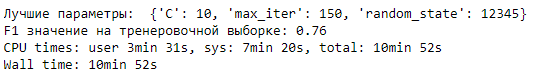

RandomForestClassifier

In [11]:
%%time
model_rfc = RandomForestClassifier(class_weight='balanced', n_jobs=-1 )
params_grid_rfc = { 'n_estimators': range(10, 51, 10),
                     'max_depth': range(5, 16, 5),
}

grid_cv = GridSearchCV(model_rfc, params_grid_rfc, scoring='f1', cv=5)
grid_cv.fit(tf_idf_train, target_train)
print('Лучшие параметры: ', grid_cv.best_params_)
print('F1 значение на тренеровочной выборке: {:.2f}'.format((grid_cv.best_score_)))

Лучшие параметры:  {'max_depth': 15, 'n_estimators': 50}
F1 значение на тренеровочной выборке: 0.37
CPU times: user 6min 49s, sys: 4.01 s, total: 6min 53s
Wall time: 6min 53s


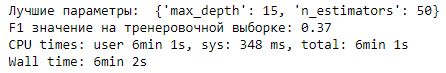

Проверим лучшую модель на тестовой выборке

In [12]:
%%time
 
model_lr = LogisticRegression(C = 10, max_iter = 150, random_state = RANDOM_STATE)

model_lr.fit(tf_idf_train, target_train)
predictions_lr = model_lr.predict(tf_idf_test)
print('F1 значение на тестовой выборке: ', f1_score(predictions_lr, target_test))

F1 значение на тестовой выборке:  0.7857538802660754
CPU times: user 30.5 s, sys: 39.6 s, total: 1min 10s
Wall time: 1min 10s


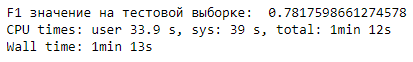

## Выводы

1. Получили первичную информацию о датафрейме. Пропусков, дублей не обнаружили.
2. Провели лемматизацию и очистку текста. Создали матрицу и указали стоп-слова.
3. Провели обучение на моделях CatBoostClassifier, LogisticRegression, RandomForestClassifier
4. Лучшее F1 значение на тренеровочной выборке у LogisticRegression - 0.76
5. F1 значение на тестовой выборке у LogisticRegression:  0.78

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны